# **P1: Presentation of the Data Processing Problem**

### **Overview**
This dataset provides detailed healthcare-related information, including patient demographics, medical conditions, treatments, and billing details.    
Each record corresponds to a patient’s admission, capturing key aspects such as medical diagnoses, hospital details, doctors, medications, and test results.

By leveraging PySpark's distributed computing capabilities, we can efficiently analyze this dataset to extract meaningful insights, identify trends, and evaluate hospital performance metrics.    
The scalability of PySpark makes it ideal for handling large-scale data processing tasks in the healthcare domain.

---

### **Dataset Breakdown**
The dataset contains the following key columns, each contributing to the understanding of patient care and hospital performance:

- **Name**: The patient’s name.
- **Age**: The age of the patient at the time of admission (in years).
- **Gender**: The patient’s gender (Male or Female).
- **Blood Type**: The patient’s blood type (e.g., A+, O-, etc.).
- **Medical Condition**: The primary diagnosis or health issue (e.g., Diabetes, Asthma, Cancer).
- **Date of Admission**: The date when the patient was admitted to the healthcare facility.
- **Doctor**: The name of the doctor responsible for the patient’s treatment.
- **Hospital**: The name of the healthcare facility where the patient was treated.
- **Insurance Provider**: The patient’s insurance company (e.g., Aetna, Medicare).
- **Billing Amount**: The total cost billed for the patient’s healthcare services.
- **Room Number**: The room assigned to the patient during their stay.
- **Admission Type**: The nature of the admission, categorized as:
  - **Emergency**
  - **Urgent**
  - **Elective**
- **Discharge Date**: The date the patient was discharged from the facility.
- **Medication**: The medication administered or prescribed during the stay (e.g., Aspirin, Paracetamol).
- **Test Results**: The outcomes of diagnostic tests, categorized as:
  - **Normal**
  - **Abnormal**
  - **Inconclusive**

---

### **The Problem**
The primary goal is to analyze and process the dataset to uncover valuable insights, identify patterns, and evaluate the performance of healthcare facilities.     
PySpark will serve as the backbone for distributed data processing, enabling scalability and efficiency.

#### **Objectives/Queries**
1. **Hospital Performance Evaluation**
   - Compare hospitals based on key metrics such as:
     - Average billing amount.
     - Number of emergency, urgent, and elective admissions.
     - Calculate custom KPI index based on weights of properties.
   - Identify hospitals with the highest number of emergency cases.

2. **Seasonal Trends**
   - Detect seasonal variations in admissions and common medical conditions.
   - Predict periods of high demand for emergency services.

3. **Patient Demographics Analysis**
   - Explore the distribution of medical conditions across different genders and age groups.
   - Examine insurance provider trends and their relationship with billing and outcomes.

4. **Analyzing Patient Length of Stay and Admission Trends**
   - Investigate patient data by identifying the top medical     condition-admission type combinations with the highest total length of stay.
   - Calculate average daily admissions for each admission type.

5. **Emergency Admission Trends**
   - Analyze emergency room data by identifying the busiest days for emergency
     admissions.
   - Visualize the weekly admission distribution.


---

### **Conclusion**
This dataset provides a comprehensive view of patient care and hospital operations, making it an excellent resource for deriving actionable insights in the healthcare domain.  
By tackling the proposed queries with PySpark, we aim to: 
- Identify trends and key performance metrics.
- Improve decision-making for hospitals and healthcare providers.
- Understand patient demographics and their impact on healthcare services.

The subsequent sections will demonstrate the PySpark implementation of these queries and analyze the performance of the distributed processing approach.


# **P2: Implementation**

Let's delve into the implementation of our project

## **Imports**

In [30]:
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import *
from pyspark.sql.functions import *
plt.style.use('ggplot')

## **Functions**

Ad-hoc functions used in this notebook

In [31]:
def time_now():  # returns current time
    now = datetime.now()
    return now.strftime('%H:%M:%S.%f')

def calculate_elapsed_time(start_time: str, end_time: str, time_format: str = '%H:%M:%S.%f') -> str: # returns elapsed time in milliseconds between two time strings
    start_dt = datetime.strptime(start_time, time_format) # start time
    end_dt = datetime.strptime(end_time, time_format) # end time

    elapsed_time_ms = int((end_dt - start_dt).total_seconds() * 1000)
    return elapsed_time_ms

## **Body**

### **Preliminary operations** 
eventual cleanings, datatype checks, null values checks, data integrity and coherence checks

In [32]:
master_configuration = "local[*]"

spark = SparkSession.builder\
    .appName("Healthcare Project")\
        .master(master_configuration)\
            .getOrCreate()
            
dataset_path = "healthcare_dataset.csv"
df = spark.read.csv(dataset_path, header=True, inferSchema=True)
df.cache()

DataFrame[Name: string, Age: int, Gender: string, Blood Type: string, Medical Condition: string, Date of Admission: date, Doctor: string, Hospital: string, Insurance Provider: string, Billing Amount: double, Room Number: int, Admission Type: string, Discharge Date: date, Medication: string, Test Results: string]

let's visualize some infos about the dataset to understand what we're dealing with and the dimension of the data

In [33]:
df.printSchema()

num_rows = df.count()
num_columns = len(df.columns)

print(f"Dataset has {num_rows} rows and {num_columns} columns.")

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood Type: string (nullable = true)
 |-- Medical Condition: string (nullable = true)
 |-- Date of Admission: date (nullable = true)
 |-- Doctor: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Insurance Provider: string (nullable = true)
 |-- Billing Amount: double (nullable = true)
 |-- Room Number: integer (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Date: date (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Test Results: string (nullable = true)

Dataset has 55500 rows and 15 columns.


showing some rows of the dataset to take a peak at the structure

In [34]:
df.show(3)

+-------------+---+------+----------+-----------------+-----------------+----------------+---------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|         Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|          Doctor|       Hospital|Insurance Provider|    Billing Amount|Room Number|Admission Type|Discharge Date| Medication|Test Results|
+-------------+---+------+----------+-----------------+-----------------+----------------+---------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|Bobby JacksOn| 30|  Male|        B-|           Cancer|       2024-01-31|   Matthew Smith|Sons and Miller|        Blue Cross|18856.281305978155|        328|        Urgent|    2024-02-02|Paracetamol|      Normal|
| LesLie TErRy| 62|  Male|        A+|          Obesity|       2019-08-20| Samantha Davies|        Kim Inc|          Medicare|33643.327286577885|        

In [35]:
# checking for duplicated rows
duplicated_rows = df.count() - df.dropDuplicates().count()
print(f"Number of duplicated rows: {duplicated_rows}")

Number of duplicated rows: 534


adding a key which is easier to handle than a composite one

In [36]:
df = df.withColumn("ID", monotonically_increasing_id())

adjusting name strings and billing amount

In [37]:
df = df.withColumn("Name", lower(col("Name")))
df = df.withColumn("Billing Amount", abs(df["Billing Amount"]))
df.show(3)

+-------------+---+------+----------+-----------------+-----------------+----------------+---------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+---+
|         Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|          Doctor|       Hospital|Insurance Provider|    Billing Amount|Room Number|Admission Type|Discharge Date| Medication|Test Results| ID|
+-------------+---+------+----------+-----------------+-----------------+----------------+---------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+---+
|bobby jackson| 30|  Male|        B-|           Cancer|       2024-01-31|   Matthew Smith|Sons and Miller|        Blue Cross|18856.281305978155|        328|        Urgent|    2024-02-02|Paracetamol|      Normal|  0|
| leslie terry| 62|  Male|        A+|          Obesity|       2019-08-20| Samantha Davies|        Kim Inc|          Medicare|33643.32728

all values a nullable (see the schema), let's check if there are some nulls values

In [38]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+----+---+------+----------+-----------------+-----------------+------+--------+------------------+--------------+-----------+--------------+--------------+----------+------------+---+
|Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|Doctor|Hospital|Insurance Provider|Billing Amount|Room Number|Admission Type|Discharge Date|Medication|Test Results| ID|
+----+---+------+----------+-----------------+-----------------+------+--------+------------------+--------------+-----------+--------------+--------------+----------+------------+---+
|   0|  0|     0|         0|                0|                0|     0|       0|                 0|             0|          0|             0|             0|         0|           0|  0|
+----+---+------+----------+-----------------+-----------------+------+--------+------------------+--------------+-----------+--------------+--------------+----------+------------+---+



seems like there are no null values, we're good to go

### **Dataset Exploration**

#### **Cross-Hospital Comparison** [first round of queries]
- Objective: Compare hospitals based on key performance indicators (KPIs) such as average billing, patient outcomes, average stay duration and type of admission.

In [39]:
starting_time = time_now()

# grouping the dataset by hospitals and calculating the average billing amount for each one
average_billing = df.groupBy("Hospital").agg(avg("Billing Amount").alias("Average Billing")) # calculate the Average Billing Amount

df = df.withColumn("Stay Duration", datediff(col("Discharge Date"), col("Date of Admission"))) # we create a new column, "Stay Duration," which represents the number of days between
                                                                                               # the admission date and the discharge date.
# how long patients stay at each hospital on average
average_stay_duration = df.groupBy("Hospital").agg(avg("Stay Duration").alias("Average Stay Duration"))

# admission type distribution
## counts how many admissions of each type occur at each hospital
admission_type_distribution = df.groupBy("Hospital", "Admission Type").count().groupBy("Hospital").pivot(
    "Admission Type", ["Emergency", "Elective", "Urgent"]
).sum("count").na.fill(0)

# combine all calculated metrics
hospital_kpis = average_billing.join(
    average_stay_duration, "Hospital"
).join(admission_type_distribution, "Hospital")

##### KPI metric computation #####

# normalizing the metrix
max_values = hospital_kpis.agg(
    {col: "max" for col in ["Average Billing", "Average Stay Duration", "Emergency", "Elective", "Urgent"]}
).collect()[0] 

normalized_kpis = hospital_kpis.select("Hospital",
    *(col(c) / lit(max_values[c]) if c in max_values else col(c) for c in hospital_kpis.columns[1:])
)

# add new column called KPI Index using a custom weighted sum of the values
hospital_kpis_with_index = normalized_kpis.withColumn(
    "KPI Index",
    0.4 * col("Average Billing")
    + 0.3 * col("Average Stay Duration")
    + 0.2 * col("Emergency")
    + 0.05 * col("Urgent")
    + 0.05 * col("Elective")
)

hospital_ranked = hospital_kpis_with_index.orderBy(col("KPI Index").desc())
print("Top 10 best hospitals based on KPI index:")
hospital_ranked.show(10)

ending_time = time_now()
analysis_1_time = calculate_elapsed_time(starting_time, ending_time)
print(f"--> queries execution started at {starting_time} and ended at {ending_time}, execution time: {analysis_1_time}ms")

Top 10 best hospitals based on KPI index:
+--------------------+------------------+---------------------+---------+--------+------+------------------+
|            Hospital|   Average Billing|Average Stay Duration|Emergency|Elective|Urgent|         KPI Index|
+--------------------+------------------+---------------------+---------+--------+------+------------------+
|    Hernandez-Morton|52373.032374241826|                 14.0|        0|       0|     2| 20953.51294969673|
|       Walker-Garcia| 52170.03685355641|                  2.0|        0|       0|     2|20868.714741422562|
|        Ruiz-Anthony|52154.237721878235|                 23.0|        0|       0|     1|20868.645088751295|
|     George-Gonzalez| 52102.24088919256|                  9.0|        1|       0|     0|20843.796355677026|
|        Rocha-Carter|52092.669895844054|                  2.0|        1|       0|     0| 20837.86795833762|
|Briggs Walker Mar...| 52024.72644288463|                 26.0|        0|       1|    

Top 5 Hospitals with Most Emergency Cases
+-----------+---------+--------+------+
|   Hospital|Emergency|Elective|Urgent|
+-----------+---------+--------+------+
|  LLC Smith|       19|      10|    15|
|  Smith Ltd|       14|      13|    10|
|  Smith PLC|       12|      14|    10|
|  Inc Jones|       12|       5|     8|
|Johnson PLC|       12|      13|    13|
+-----------+---------+--------+------+



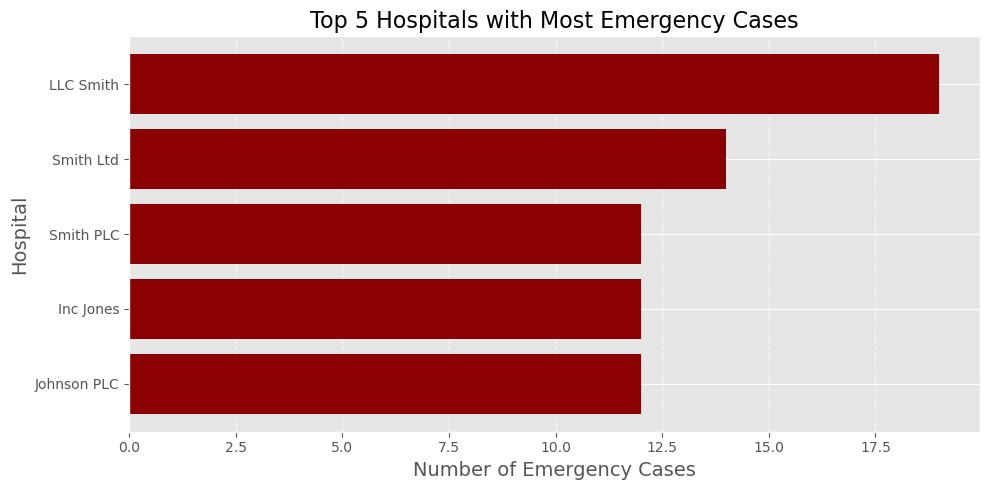

In [40]:
top_emergency_data = hospital_kpis.orderBy(col("Emergency").desc()).limit(5) # get the top 5 hospitals with the most emergency cases

print("Top 5 Hospitals with Most Emergency Cases")
top_emergency_data = top_emergency_data.select("Hospital", "Emergency", "Elective", "Urgent")
top_emergency_data.show()

top_emergency_data = top_emergency_data.collect()

top_emergency_hospitals = [row["Hospital"] for row in top_emergency_data]
top_emergency_counts = [row["Emergency"] for row in top_emergency_data]

########## Plotting ##########
plt.figure(figsize=(10, 5))
plt.barh(top_emergency_hospitals, top_emergency_counts, color="darkred")
plt.title("Top 5 Hospitals with Most Emergency Cases", fontsize=16)
plt.xlabel("Number of Emergency Cases", fontsize=14)
plt.ylabel("Hospital", fontsize=14)
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Top 10 Hospitals based on KPI index
+--------------------+------------------+
|            Hospital|         KPI Index|
+--------------------+------------------+
|    Hernandez-Morton| 20953.51294969673|
|       Walker-Garcia|20868.714741422562|
|        Ruiz-Anthony|20868.645088751295|
|     George-Gonzalez|20843.796355677026|
|        Rocha-Carter| 20837.86795833762|
|Briggs Walker Mar...|20817.740577153854|
|and Small Stephen...|20798.587254106522|
|      Clark-Espinoza|20741.730638672587|
|        Stephens Ltd|20693.870348396034|
|Pierce and Miller...| 20690.99909574611|
+--------------------+------------------+



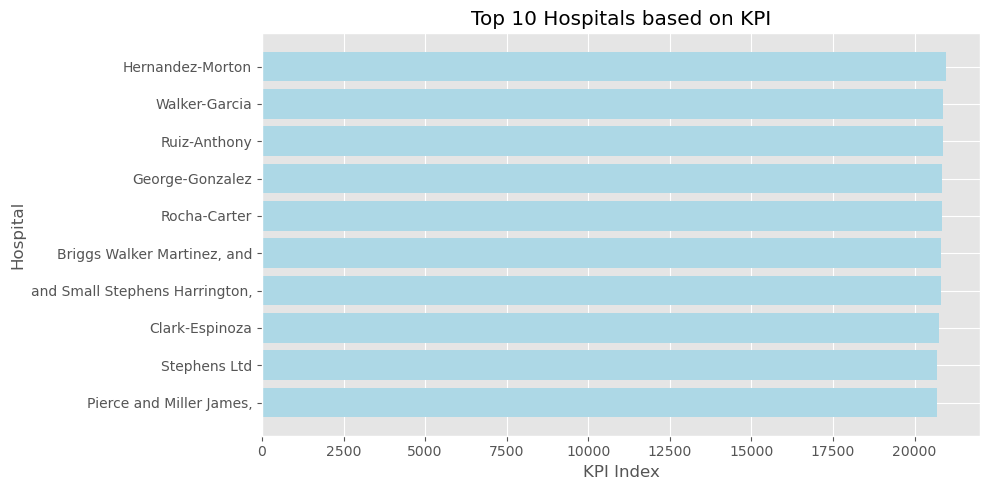

In [41]:
# Let's sort by KPI index and select the top 10 hospitals
top_hospitals = hospital_ranked.orderBy(col("KPI Index").desc()).limit(10)
print("Top 10 Hospitals based on KPI index")
top_hospitals = top_hospitals.select(["Hospital","KPI Index"])
top_hospitals.show()

top_hospitals = top_hospitals.collect()

top_hospitals_name = [row['Hospital'] for row in top_hospitals]
top_hospitals_KPI = [row['KPI Index'] for row in top_hospitals]

################ plotting ################
plt.figure(figsize=(10, 5))
plt.barh(top_hospitals_name, top_hospitals_KPI, color="lightblue")
plt.title("Top 10 Hospitals based on KPI")
plt.xlabel("KPI Index")
plt.ylabel("Hospital")
plt.gca().invert_yaxis()  # To show the highest bar at the top
plt.tight_layout()
plt.show()

#### **Seasonal Trends in Admissions** [second round of queries]
- Objective: Identify seasonal patterns in admissions and medical conditions to plan for future demands in healthcare services.

In [42]:
# adding a "Season" column based on the month of Date of Admission
df = df.withColumn(
    "Season",
    when(month(col("Date of Admission")).isin(3, 4, 5), "Spring")
    .when(month(col("Date of Admission")).isin(6, 7, 8), "Summer")
    .when(month(col("Date of Admission")).isin(9, 10, 11), "Autumn")
    .when(month(col("Date of Admission")).isin(12, 1, 2), "Winter")
)

starting_time = time_now()

df.select("Season").distinct().show()

+------+
|Season|
+------+
|Spring|
|Summer|
|Autumn|
|Winter|
+------+



In [43]:
# grouping by Season and Medical Condition, and also count admissions
seasonal_counts = df.groupBy("Season", "Medical Condition").agg(count("*").alias("Admission Count")) # count the number of admissions for each medical condition in each season

# the following code calculates the rank of each medical condition within each season based on the number of admissions.
# Then, it filters the rows with rank 1, which corresponds to the most common medical condition in each season.
most_common_conditions = seasonal_counts.withColumn(
    "Rank",
    row_number().over(Window.partitionBy("Season").orderBy(col("Admission Count").desc()))
).filter(col("Rank") == 1) # filter the most common medical condition in each season

# finding the season with the most admissions overall
seasonal_totals = df.groupBy("Season").agg(count("*").alias("Total Admissions"))
most_admissions_season = seasonal_totals.orderBy(col("Total Admissions").desc())

print("Most Common Medical Conditions per Season:")
most_common_conditions.select("Season", "Medical Condition", "Admission Count").show() # showing the most common medical condition in each season

ending_time = time_now()

most_admissions_season.show() # showing the seasons with the most admissions overall

print("Season with the Most Admissions:")
most_admissions_season.show(1) # showing the season with the most admissions overall

analysis_2_time = calculate_elapsed_time(starting_time, ending_time)
print(f"--> queries execution started at {starting_time} and ended at {ending_time}, execution time: {analysis_2_time}ms")

Most Common Medical Conditions per Season:
+------+-----------------+---------------+
|Season|Medical Condition|Admission Count|
+------+-----------------+---------------+
|Autumn|         Diabetes|           2346|
|Spring|           Cancer|           2335|
|Summer|        Arthritis|           2447|
|Winter|        Arthritis|           2348|
+------+-----------------+---------------+

+------+----------------+
|Season|Total Admissions|
+------+----------------+
|Summer|           14343|
|Spring|           13789|
|Autumn|           13772|
|Winter|           13596|
+------+----------------+

Season with the Most Admissions:
+------+----------------+
|Season|Total Admissions|
+------+----------------+
|Summer|           14343|
+------+----------------+
only showing top 1 row

--> queries execution started at 04:22:02.843302 and ended at 04:22:03.146189, execution time: 302ms


#### **Demographic: Analysis of Top Medical Conditions by Age Group and Gender** [third round of queries]

+-----------------+--------+
|Medical Condition|Patients|
+-----------------+--------+
|          Obesity|    9231|
|         Diabetes|    9304|
|        Arthritis|    9308|
|     Hypertension|    9245|
|           Cancer|    9227|
|           Asthma|    9185|
+-----------------+--------+



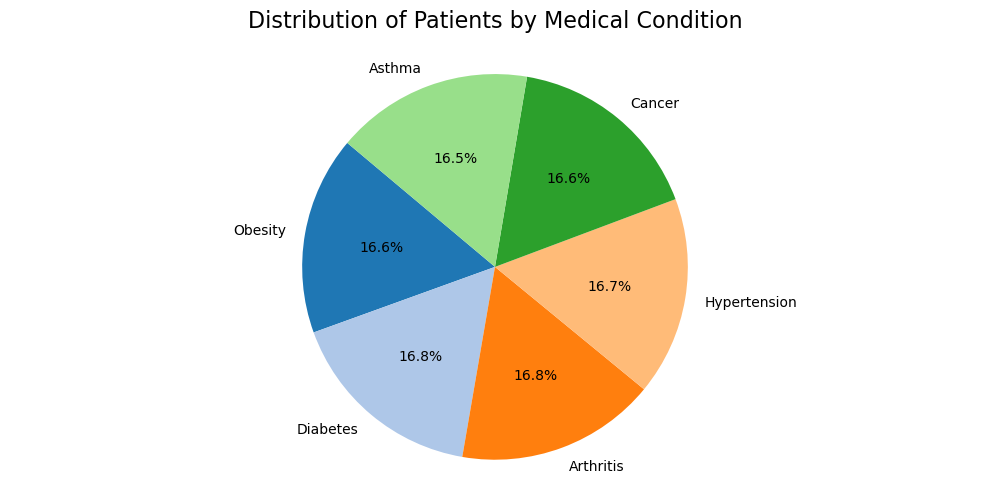

In [44]:
starting_time = time_now()

patients_by_condition = df.groupBy("Medical Condition").agg(count("ID").alias("Patients")) # count the number of patients for each medical condition
patients_by_condition.show()

# collect the data to be used in the pie chart
conditions = [row['Medical Condition'] for row in patients_by_condition.select("Medical Condition").collect()]
patients = [row['Patients'] for row in patients_by_condition.select("Patients").collect()]

########## plotting ##########
plt.figure(figsize=(10, 5))
plt.pie(
    patients,
    labels=conditions,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab20.colors
)

plt.title("Distribution of Patients by Medical Condition", fontsize=16, pad=20)
plt.axis('equal') 
plt.tight_layout()
plt.show()

In [45]:
# count the number of patients for each medical condition in each age group
medical_condition_per_age = df.groupBy("Medical Condition", "Age").agg(count("ID").alias("Patients")).orderBy("Age", ascending=True) 
medical_condition_per_age.show(3) # just to make sure the data is correct

+-----------------+---+--------+
|Medical Condition|Age|Patients|
+-----------------+---+--------+
|           Cancer| 13|       2|
|          Obesity| 13|       6|
|     Hypertension| 13|       1|
+-----------------+---+--------+
only showing top 3 rows



In [46]:
window_spec = Window.partitionBy("Age").orderBy(col("Patients").desc()) 

ranked_conditions = medical_condition_per_age.withColumn("Rank", row_number().over(window_spec)) # adding rank to all rows in the window

top_conditions_by_age_group = ranked_conditions.filter(col("Rank") == 1)# retrieve the rank 1 for each window partition

top_conditions_by_age_group.select("Age", "Medical Condition", "Patients").show(10) # just to make sure the data is correct

+---+-----------------+--------+
|Age|Medical Condition|Patients|
+---+-----------------+--------+
| 13|          Obesity|       6|
| 14|          Obesity|       6|
| 15|           Asthma|       8|
| 16|           Cancer|       5|
| 17|        Arthritis|      10|
| 18|     Hypertension|     132|
| 19|        Arthritis|     148|
| 20|           Cancer|     134|
| 21|     Hypertension|     165|
| 22|          Obesity|     150|
+---+-----------------+--------+
only showing top 10 rows



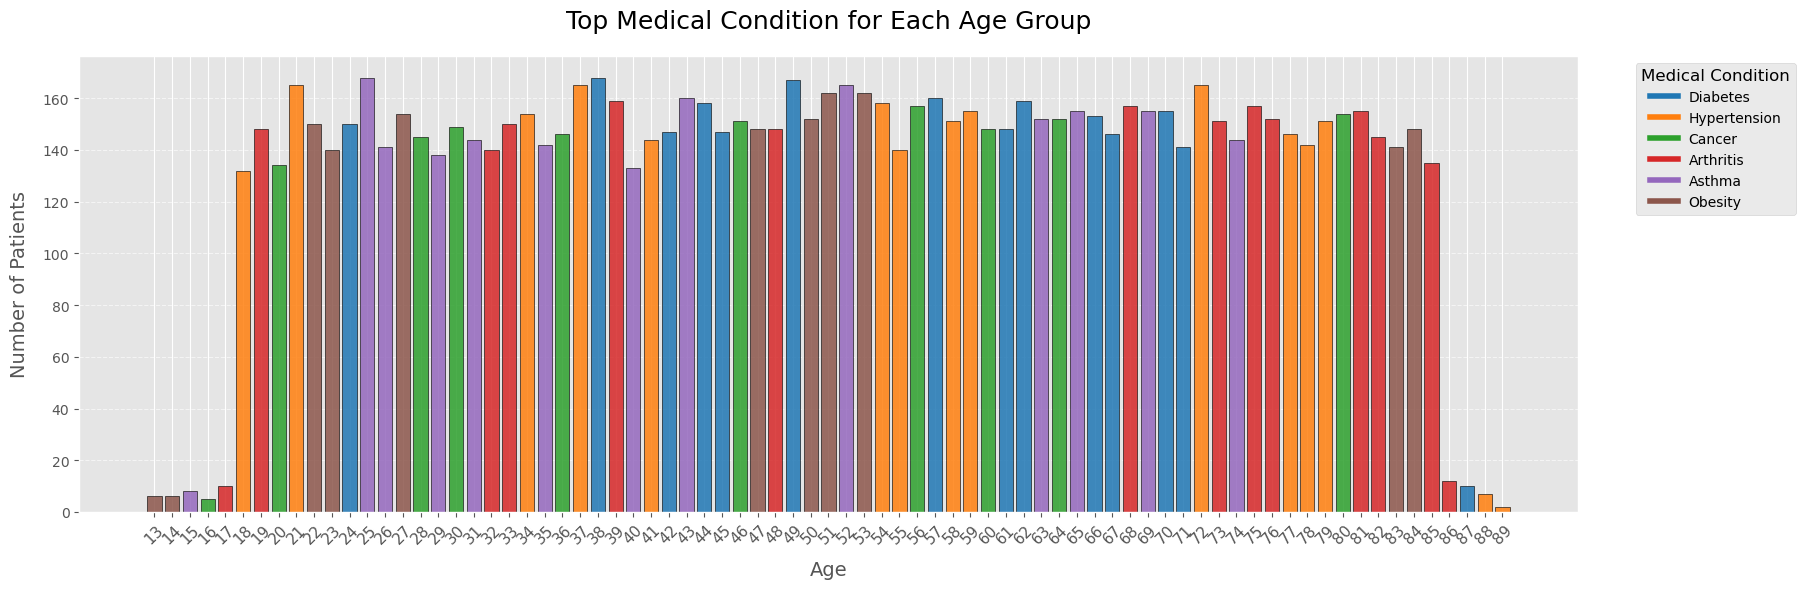

--> queries execution started at 04:22:03.276190 and ended at 04:22:04.785821, execution time: 1509ms


In [47]:
# collecting tha data to make plotting more handy
ages = [row['Age'] for row in top_conditions_by_age_group.select("Age").collect()]
patients = [row['Patients'] for row in top_conditions_by_age_group.select("Patients").collect()]
conditions = [row['Medical Condition'] for row in top_conditions_by_age_group.select("Medical Condition").collect()]

########### plotting ###########
unique_conditions = list(set(conditions)) # get the unique medical conditions (the usage of set() is to remove duplicates), it could've also been handle differently
color_map = {condition: plt.cm.tab10(i % 10) for i, condition in enumerate(unique_conditions)} # assign a color to each medical condition
colors = [color_map[condition] for condition in conditions] # get the color for each medical condition

plt.figure(figsize=(18, 6))
bars = plt.bar(ages, patients, color=colors, alpha=0.85, edgecolor='black')

plt.title("Top Medical Condition for Each Age Group", fontsize=18, pad=20)
plt.xlabel("Age", fontsize=14, labelpad=10)
plt.ylabel("Number of Patients", fontsize=14, labelpad=10)
plt.xticks(ages, fontsize=11, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

legend_patches = [plt.Line2D([0], [0], color=color_map[condition], lw=4, label=condition) for condition in unique_conditions] # create legend patches
plt.legend(handles=legend_patches, title="Medical Condition", title_fontsize=12, fontsize=10, loc='upper right', bbox_to_anchor=(1.15, 1)) 
plt.tight_layout()
plt.show()

ending_time = time_now()
print(f"--> queries execution started at {starting_time} and ended at {ending_time}, execution time: {calculate_elapsed_time(starting_time, ending_time)}ms")

Gender and Medical Conditions:
+------+-----------------+--------+
|Gender|Medical Condition|Patients|
+------+-----------------+--------+
|Female|        Arthritis|    4686|
|Female|     Hypertension|    4612|
|Female|           Cancer|    4602|
|Female|         Diabetes|    4651|
|Female|          Obesity|    4622|
|Female|           Asthma|    4553|
|  Male|     Hypertension|    4633|
|  Male|           Asthma|    4632|
|  Male|        Arthritis|    4622|
|  Male|          Obesity|    4609|
|  Male|         Diabetes|    4653|
|  Male|           Cancer|    4625|
+------+-----------------+--------+

--> queries execution started at 04:22:03.276190 and ended at 04:22:05.163485, execution time: 1887ms


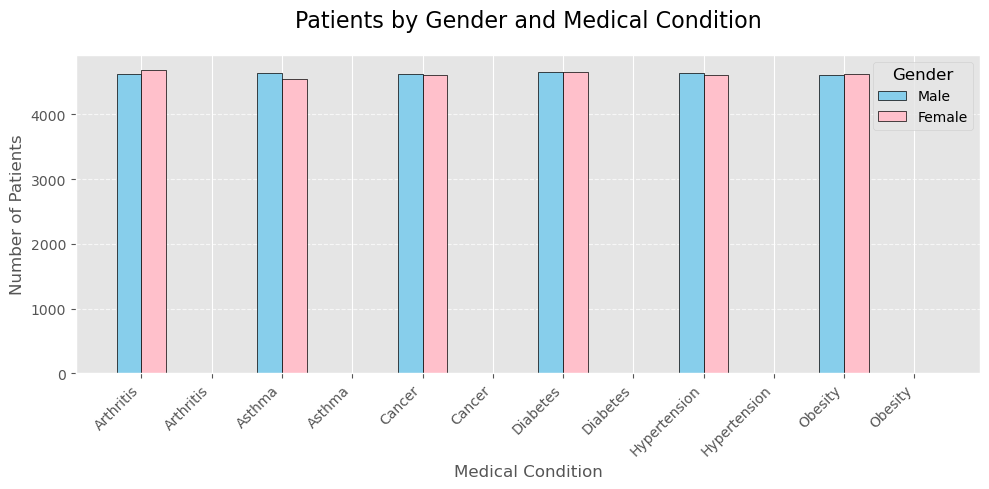

In [48]:
gender_condition = df.groupBy("Gender", "Medical Condition").agg(count("ID").alias("Patients")).orderBy("Gender", ascendent=True) # count the number of patients for each medical condition by gender
print("Gender and Medical Conditions:")
gender_condition.show() 

genders = [row["Gender"] for row in gender_condition.select('Gender').collect()] # get unique genders
conditions = [row["Medical Condition"] for row in gender_condition.select('Medical Condition').collect()] # get the unique medical conditions
patients = [row["Patients"] for row in gender_condition.select('Patients').collect()] # get the number of patients for each medical condition
conditions.sort()  

patients_by_gender = {gender: [0] * len(conditions) for gender in genders} # initialize a dictionary to store the number of patients for

for row in gender_condition.collect(): # fill the dictionary with the number of patients for each
    condition_idx = conditions.index(row["Medical Condition"]) # get the index of the medical condition
    patients_by_gender[row["Gender"]][condition_idx] += row["Patients"] # add the number of patients to the corresponding index
    
ending_time = time_now()
analysis_3_time = calculate_elapsed_time(starting_time, ending_time)
print(f"--> queries execution started at {starting_time} and ended at {ending_time}, execution time: {analysis_3_time}ms")

########## plotting ##########
x = np.arange(len(conditions)) 
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 5))

bars_male = ax.bar(
    x - width / 2, 
    patients_by_gender.get("Male", [0] * len(conditions)), 
    width, 
    label="Male", 
    color="skyblue", 
    edgecolor="black"
)
bars_female = ax.bar(
    x + width / 2, 
    patients_by_gender.get("Female", [0] * len(conditions)), 
    width, 
    label="Female", 
    color="pink", 
    edgecolor="black"
)
ax.set_xlabel("Medical Condition", fontsize=12)
ax.set_ylabel("Number of Patients", fontsize=12)
ax.set_title("Patients by Gender and Medical Condition", fontsize=16, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(conditions, rotation=45, ha="right", fontsize=10)
ax.legend(title="Gender", fontsize=10, title_fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

#### **Analyzing Patients Length of Stay and Admission Trends** [fourth round of queries]

- Objective: To investigate patient data by identifying the top medical condition-admission type combinations with the highest total length of stay and calculating average daily admissions for each admission type, providing insights for resource allocation and operational efficiency.

In [49]:
starting_time = time_now()

df = df.withColumn("Date of Admission", to_date("Date of Admission", "yyyy-MM-dd")) \
       .withColumn("Discharge Date", to_date("Discharge Date", "yyyy-MM-dd")) # converting to date type admision and discharge date

group_stats = df.groupBy("Medical Condition", "Admission Type").agg(
    count("*").alias("Patient_Count"),
    sum("Stay Duration").alias("Total Length of Stay"),
    avg("Stay Duration").alias("Avg Length of Stay")
) # grouping by medical condition and admission type and calculating patient count, total length of stay and average length of stay

top_5_groups = group_stats.orderBy(desc("Total Length of Stay")).limit(5) # getting top 5 groups with highest total length of stay
print("Top 5 groups with the highest total length of stay:")
top_5_groups.show()

# get average admissions for each admission type
daily_admissions = df.groupBy("Admission Type", "Date of Admission").count()\
    .groupBy("Admission Type").agg(
        avg("count").alias("Avg_Daily_Admissions")
    )

print("Average daily admissions per admission type:") # this info could be useful for hospital managing their resources
daily_admissions.show()

ending_time = time_now()

analysis_4_time = calculate_elapsed_time(starting_time, ending_time)
print(f"--> queries execution started at {starting_time} and ended at {ending_time}, execution time: {analysis_4_time}ms")

Top 5 groups with the highest total length of stay:
+-----------------+--------------+-------------+--------------------+------------------+
|Medical Condition|Admission Type|Patient_Count|Total Length of Stay|Avg Length of Stay|
+-----------------+--------------+-------------+--------------------+------------------+
|     Hypertension|      Elective|         3221|               49843|15.474386836386216|
|           Asthma|      Elective|         3102|               48836|15.743391360412637|
|         Diabetes|        Urgent|         3229|               48729|15.091049860637968|
|           Asthma|        Urgent|         3081|               48573|15.765335929892892|
|          Obesity|     Emergency|         3126|               48508|15.517594369801664|
+-----------------+--------------+-------------+--------------------+------------------+

Average daily admissions per admission type:
+--------------+--------------------+
|Admission Type|Avg_Daily_Admissions|
+--------------+---------

#### **Emergency Admission Trends** [fifth round of queries]

- Objective: To analyze emergency room data by identifying the busiest days for emergency admissions, visualizing the weekly admission distribution.

Top 2 Busiest Days for Emergency Admissions:
+-----------+-----+
|Day_of_Week|count|
+-----------+-----+
|        Tue| 2645|
|        Fri| 2628|
+-----------+-----+

+-----------+-----+
|Day_of_Week|count|
+-----------+-----+
|        Tue| 2645|
|        Fri| 2628|
|        Thu| 2609|
|        Sun| 2602|
|        Mon| 2597|
|        Wed| 2597|
|        Sat| 2591|
+-----------+-----+

--> queries execution started at 04:22:05.569107 and ended at 04:22:05.714121, execution time: 145ms


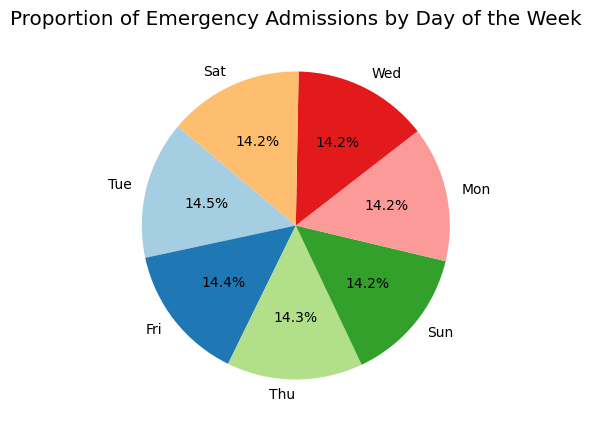

In [50]:
starting_time = time_now()

emergency_cases = df.filter(col("Admission Type") == "Emergency")

emergency_cases = emergency_cases.withColumn("Day_of_Week", date_format("Date of Admission", "E")) # get the day of the week for each admission emergency case

admissions_by_day = emergency_cases.groupBy("Day_of_Week").count().orderBy(desc("count")) # count the number of emergency admissions for each day of the week

# Display the top 2 busiest days for emergency admissions
top_2_days = admissions_by_day.limit(2)
print("Top 2 Busiest Days for Emergency Admissions:")
top_2_days.show()
admissions_by_day.show()


ending_time = time_now()
analysis_5_time = calculate_elapsed_time(starting_time, ending_time)
print(f"--> queries execution started at {starting_time} and ended at {ending_time}, execution time: {analysis_5_time}ms")

########## plotting ##########
admissions_data = admissions_by_day.collect()
days = [row["Day_of_Week"] for row in admissions_data]
counts = [row["count"] for row in admissions_data]

plt.figure(figsize=(10, 5))
plt.pie(counts, labels=days, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Proportion of Emergency Admissions by Day of the Week")
plt.show()

#### **Clustering Patients** [sixth round of queries + ML]

Clustering patients admission is useful to highlight underlying common patterns in patients admission criteria and promptly identify possible medications with the use of similar patients history.  
Here patients are not treated as a mean to understand better the nature of an admission. Readmissions in real case scenarios are possible, that's why  
we're considering admissions as a real life entity and not the single patient.

In [51]:
starting_time = time_now()

dataset_patients = df.select("ID", "Age", "Stay Duration", "Medical Condition", "Billing Amount")

tokenizer = Tokenizer(inputCol="Medical Condition", outputCol="Medical Condition Tokens") # tokenize the medical condition 
tokenized = tokenizer.transform(dataset_patients)

hashingTF = HashingTF(inputCol="Medical Condition Tokens", outputCol="Medical Condition Hashed", numFeatures=42) # hash the medical condition tokens
featurized = hashingTF.transform(tokenized)

assembler = VectorAssembler(inputCols=["Age", "Stay Duration", "Billing Amount", "Medical Condition Hashed"], outputCol="features") # assemble the features
dataset_for_clustering = assembler.transform(featurized)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False) # scale the features
dataset_for_clustering = scaler.fit(dataset_for_clustering).transform(dataset_for_clustering)

dataset_for_clustering = dataset_for_clustering.drop("Medical Condition Tokens", "features", "Medical Condition Hashed") # drop the intermediate columns

evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean") # create a clustering evaluator to evaluate the clustering model

# using the silhouette score to find the best k value, also elbow method could've been used but  
best_k = 0
max_silhouette = 0
for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=1)
    model = kmeans.fit(dataset_for_clustering)
    predictions = model.transform(dataset_for_clustering)
    silhouette = evaluator.evaluate(predictions)
    if silhouette > max_silhouette:
        best_k = k
        max_silhouette = silhouette
    print(f"k={k}, Silhouette Score={silhouette}")

print(f"Best k value: {best_k}, Best Silhouette Score: {max_silhouette}")

# training and evaluating the model with the best k value
kmeans = KMeans(featuresCol="scaled_features", k=best_k, seed=1)
model = kmeans.fit(dataset_for_clustering)
patients = model.transform(dataset_for_clustering)
patients.show(10, truncate=False)

k=2, Silhouette Score=0.236057474283989
k=3, Silhouette Score=0.35383027571667397
k=4, Silhouette Score=0.47196363130343083
k=5, Silhouette Score=0.5906544168810951


k=6, Silhouette Score=0.7090226717164146
k=7, Silhouette Score=0.6355813074543445
k=8, Silhouette Score=0.5778836336612297
k=9, Silhouette Score=0.5263142583510403
k=10, Silhouette Score=0.47711730606744945
Best k value: 6, Best Silhouette Score: 0.7090226717164146
+---+---+-------------+-----------------+------------------+---------------------------------------------------------------------------------------------+----------+
|ID |Age|Stay Duration|Medical Condition|Billing Amount    |scaled_features                                                                              |prediction|
+---+---+-------------+-----------------+------------------+---------------------------------------------------------------------------------------------+----------+
|0  |30 |2            |Cancer           |18856.281305978155|(45,[0,1,2,30],[1.5304206449383075,0.23095754502755392,1.3271630214209447,2.685931804509602])|2         |
|1  |62 |6            |Obesity          |33643.327286577885|(45,[0,1,2

In [52]:

# Group patients by their assigned cluster and compute aggregate statistics
grouped_patients = patients.groupBy("prediction").agg(
    count("ID").alias("Number of Patients"),
    avg("Age").alias("Average Age"),
    min("Age").alias("Minimum Age"),
    max("Age").alias("Maximum Age"),
    avg("Stay Duration").alias("Average Stay Duration"),
    min("Stay Duration").alias("Minimum Stay Duration"),
    max("Stay Duration").alias("Maximum Stay Duration"),
    avg("Billing Amount").alias("Average Billing Amount"),
    min("Billing Amount").alias("Minimum Billing Amount"),
    max("Billing Amount").alias("Maximum Billing Amount")
)

# Show the grouped results
grouped_patients.show()

ending_time = time_now()
analysis_6_time = calculate_elapsed_time(starting_time, ending_time)
print(f"--> queries execution started at {starting_time} and ended at {ending_time}, execution time: {analysis_6_time}ms")

+----------+------------------+------------------+-----------+-----------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+
|prediction|Number of Patients|       Average Age|Minimum Age|Maximum Age|Average Stay Duration|Minimum Stay Duration|Maximum Stay Duration|Average Billing Amount|Minimum Billing Amount|Maximum Billing Amount|
+----------+------------------+------------------+-----------+-----------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+
|         1|              9304| 51.55417024935512|         14|         89|   15.422936371453138|                    1|                   30|     25640.13433762909|    31.030955450754846|     52211.85296638021|
|         3|              9308| 51.56532015470563|         13|         89|   15.517404383326172|                    1|                   30|    25498.5834374994

#### **Clustering Doctors** [seventh round of queries + ML]

In [53]:
starting_time = time_now()

dataset_doctors = df.groupBy("Doctor").agg(
    count("ID").alias("Number of Patients"),
    avg("Billing Amount").alias("Average Billing Amount"),
    avg("Stay Duration").alias("Average Stay Duration"),
    count("Medical Condition").alias("Unique Medical Conditions Treated"),
    collect_list("Medical Condition").alias("Medical Condition List")
)

dataset_doctors = dataset_doctors.withColumn(
    "Medical Condition Flattened",
    concat_ws(" ", "Medical Condition List")
).drop("Medical Condition List")  # flatten the list of medical conditions into a single string

tokenizer = Tokenizer(inputCol="Medical Condition Flattened", outputCol="Medical Condition Tokens")
tokenized = tokenizer.transform(dataset_doctors)

hashingTF = HashingTF(inputCol="Medical Condition Tokens", outputCol="Medical Condition Hashed", numFeatures=42)
featurized = hashingTF.transform(tokenized)

assembler = VectorAssembler(inputCols=[
    "Number of Patients", 
    "Average Billing Amount", 
    "Average Stay Duration", 
    "Unique Medical Conditions Treated", 
    "Medical Condition Hashed"
], outputCol="features")
dataset_for_clustering = assembler.transform(featurized)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
dataset_for_clustering = scaler.fit(dataset_for_clustering).transform(dataset_for_clustering)

dataset_for_clustering = dataset_for_clustering.drop("Medical Condition Tokens", "Medical Condition Hashed", "features")

evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

max_k = 0
max_silhouette = 0
for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=1)
    model = kmeans.fit(dataset_for_clustering)
    predictions = model.transform(dataset_for_clustering)
    silhouette = evaluator.evaluate(predictions)
    if silhouette > max_silhouette:
        max_k = k
        max_silhouette = silhouette
    print(f"k={k}, Silhouette Score={silhouette}")

print(f"Best k value: {max_k}, Best Silhouette Score: {max_silhouette}")

kmeans = KMeans(featuresCol="scaled_features", k=max_k, seed=1)
model = kmeans.fit(dataset_for_clustering)
doctors = model.transform(dataset_for_clustering)
doctors.show(10, truncate=False)

k=2, Silhouette Score=0.656170463627863
k=3, Silhouette Score=0.4799113336870479
k=4, Silhouette Score=0.2761502957409847
k=5, Silhouette Score=0.36830501387873693
k=6, Silhouette Score=0.45160279425193384
k=7, Silhouette Score=0.5276321953973236
k=8, Silhouette Score=0.43217471919126627
k=9, Silhouette Score=0.4307457526066896
k=10, Silhouette Score=0.3990032784123424
Best k value: 2, Best Silhouette Score: 0.656170463627863
+-----------------+------------------+----------------------+---------------------+---------------------------------+---------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|Doctor           |Number of Patients|Average Billing Amount|Average Stay Duration|Unique Medical Conditions Treated|Medical Condition Flattened                        |scaled_features                            

In [54]:
grouped_doctors = doctors.groupBy("prediction").agg(
    count("Doctor").alias("Number of Doctors"),
    avg("Number of Patients").alias("Average Number of Patients"),
    avg("Average Billing Amount").alias("Average Billing Amount"),
    avg("Average Stay Duration").alias("Average Stay Duration"),
    avg("Unique Medical Conditions Treated").alias("Average Unique Conditions")
)

grouped_doctors.show(truncate=False)

ending_time = time_now()
analysis_7_time = calculate_elapsed_time(starting_time, ending_time)
print(f"--> queries execution started at {starting_time} and ended at {ending_time}, execution time: {analysis_7_time}ms")

+----------+-----------------+--------------------------+----------------------+---------------------+-------------------------+
|prediction|Number of Doctors|Average Number of Patients|Average Billing Amount|Average Stay Duration|Average Unique Conditions|
+----------+-----------------+--------------------------+----------------------+---------------------+-------------------------+
|1         |3397             |3.587871651457168         |25354.59790957738     |15.603407572963658   |3.587871651457168        |
|0         |36944            |1.1723689909051538        |25590.374342654613    |15.488644976180165   |1.1723689909051538       |
+----------+-----------------+--------------------------+----------------------+---------------------+-------------------------+

--> queries execution started at 04:22:18.025228 and ended at 04:22:38.723878, execution time: 20698ms


In [55]:
spark.stop()

# **P3: Performance Evaluation**

#### **Cluster Mode vs Local Execution**

This final part evaluates the performance of a Spark program when executed in two different environments. The first environment is our university cluster of 10 computers. The second environment involves running the program locally on a single machine, which is tested in the following configurations: single core (`local[1]`), two cores, and using all available core (`local[*]`). 

**dataset description**: 55000 rows, 15 columns [≈8MB]
 
results:

| **Mode**                | **Average Execution Time** (ms) |
|--------------------------|--------------------|
| `cluster mode`           | ≈ 413017      |
| `local[1]`| ≈ 39008       |
| `local[2]` | ≈ 31258       |
| `local[*]`| ≈ 28624      |                  
                               
*The reported times represent the average of 10 runs for each configuration*


The significant difference in execution times between cluster mode and local execution highlights the impact of workload distribution and system overhead on performance. In cluster mode, Spark distributes the dataset into partitions and sends tasks to multiple worker nodes in the cluster. This process involves overhead such as communication between the driver and workers, data shuffling, and coordination of tasks. For small datasets like the one used in this experiment (8MB), the communication and coordination overhead become the dominant factors, leading to much slower execution compared to local processing. Distributed systems like Spark are designed for large-scale datasets, where the benefits of parallel computation outweigh these overheads. However, for small workloads, such overhead can render cluster mode inefficient.

On the other hand, local execution demonstrates a substantial performance advantage due to the absence of such overhead. When running with a single thread (`local[1]`), the program executes each task sequentially. Although this is slower than using multiple threads, it still outperforms cluster mode by avoiding distributed communication. When executed with all available threads (`local[*]`), Spark leverages all CPU cores on the local machine to parallelize the workload, further reducing execution time. This improvement highlights the efficiency of parallel processing at the local level, where Spark can process tasks concurrently without the need for inter-node communication. 

Interestingly, the difference in execution times between `local[1]` and `local[*]` is not as significant as one might expect for this dataset size. This could be attributed to the relatively small dataset, where the overhead of managing parallel threads is comparable to the benefits gained from parallel execution.

summary:

| **Execution Environment** | **Performance Impact**                                         |
|----------------------------|---------------------------------------------------------------|
| **Cluster Mode**           | Slower due to distributed computing overhead and small dataset. |
| **Local Mode (1 Thread)**  | Faster than cluster mode but limited by single-thread execution. |
| **Local Mode (local[*])**  | Fastest as it utilizes all available CPU cores for parallelism. |

This experiment underscores the importance of choosing the appropriate execution environment based on the size of the dataset and the characteristics of the workload. Cluster mode, while powerful for large datasets, introduces significant overhead when processing smaller data, making it a suboptimal choice in this scenario. Local execution, particularly with `local[*]`, proves to be the most efficient option, as it capitalizes on the available computational resources without incurring the overhead of distributed communication. 

Ultimately this introduces a trade-off where, for small datasets like the one used here, local execution is to be chosen, while cluster mode should be reserved for larger datasets where the benefits of distributed computation justify its overhead.
